YCbCr conversion complete.
Chroma sub-sampling complete.


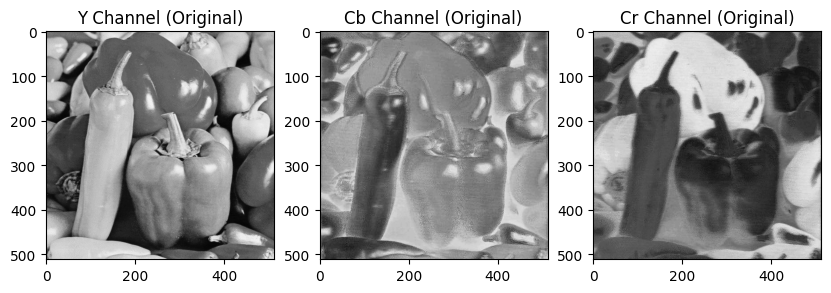

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt  # Use for displaying in notebooks or Google Colab

# Load the image
image_path = '/content/peppers_color.jpg'
image_rgb = cv2.imread(image_path)
height, width, _ = image_rgb.shape

# Step 1: Convert RGB to YCbCr
def rgb_to_ycbcr(image):
    ycbcr_image = np.zeros_like(image, dtype=float)
    R = image[:, :, 2].astype(float)
    G = image[:, :, 1].astype(float)
    B = image[:, :, 0].astype(float)

    ycbcr_image[:, :, 0] = 0.299 * R + 0.587 * G + 0.114 * B             # Y channel
    ycbcr_image[:, :, 1] = 128 - 0.168736 * R - 0.331264 * G + 0.5 * B    # Cb channel
    ycbcr_image[:, :, 2] = 128 + 0.5 * R - 0.418688 * G - 0.081312 * B    # Cr channel

    return ycbcr_image

# Sub-sampling function (4:2:0 subsampling)
def chroma_subsample(ycbcr_image):
    Y = ycbcr_image[:, :, 0]  # Y channel
    Cb = ycbcr_image[:, :, 1]  # Cb channel
    Cr = ycbcr_image[:, :, 2]  # Cr channel

    # Sub-sampling Cb and Cr by a factor of 2 (4:2:0)
    Cb_sub = Cb[::2, ::2]  # Down-sample Cb
    Cr_sub = Cr[::2, ::2]  # Down-sample Cr

    # Create the subsampled YCbCr image
    # Since the Y channel is not sub-sampled, we use the original Y channel
    subsampled_ycbcr = np.zeros_like(ycbcr_image, dtype=float)
    subsampled_ycbcr[:, :, 0] = Y  # Y channel remains the same
    subsampled_ycbcr[::2, ::2, 1] = Cb_sub  # Cb is sub-sampled
    subsampled_ycbcr[::2, ::2, 2] = Cr_sub  # Cr is sub-sampled

    return subsampled_ycbcr

# Perform the YCbCr conversion
ycbcr_image = rgb_to_ycbcr(image_rgb)
print("YCbCr conversion complete.")

# Perform chroma sub-sampling (4:2:0)
subsampled_ycbcr = chroma_subsample(ycbcr_image)
print("Chroma sub-sampling complete.")
# Split channels for original and subsampled images
Y_channel = ycbcr_image[:, :, 0]
Cb_channel = ycbcr_image[:, :, 1]
Cr_channel = ycbcr_image[:, :, 2]

subsampled_Y = subsampled_ycbcr[:, :, 0]
subsampled_Cb = subsampled_ycbcr[:, :, 1]
subsampled_Cr = subsampled_ycbcr[:, :, 2]

# Display each channel and the subsampled channels in a row (total 6 images)
plt.figure(figsize=(10, 10))  # Adjust figure size to accommodate all channels

# Original Y, Cb, Cr channels
plt.subplot(2, 3, 1)
plt.imshow(Y_channel, cmap='gray')
plt.title("Y Channel (Original)")

plt.subplot(2, 3, 2)
plt.imshow(Cb_channel, cmap='gray')
plt.title("Cb Channel (Original)")

plt.subplot(2, 3, 3)
plt.imshow(Cr_channel, cmap='gray')
plt.title("Cr Channel (Original)")
plt.show()
# Define DCT and Quantization functions




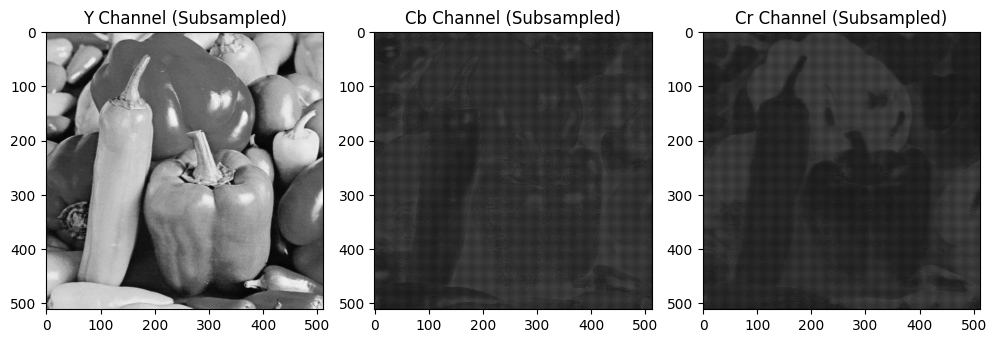

In [ ]:
# Subsampled Y, Cb, Cr channels
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(subsampled_Y, cmap='gray')
plt.title("Y Channel (Subsampled)")

plt.subplot(1, 3, 2)
plt.imshow(subsampled_Cb, cmap='gray')
plt.title("Cb Channel (Subsampled)")

plt.subplot(1, 3, 3)
plt.imshow(subsampled_Cr, cmap='gray')
plt.title("Cr Channel (Subsampled)")

plt.tight_layout()  # Adjust the layout to make sure everything fits
plt.show()

In [ ]:
# Define DCT and Quantization functions

# DCT function for an 8x8 block
def dct_2d(block):
    dct_block = np.zeros((8, 8), dtype=float)
    for u in range(8):
        for v in range(8):
            sum_val = 0
            for x in range(8):
                for y in range(8):
                    sum_val += block[x, y] * np.cos((2 * x + 1) * u * np.pi / 16) * np.cos((2 * y + 1) * v * np.pi / 16)
            dct_block[u, v] = sum_val * (1 / 4) * (1/np.sqrt(2) if u == 0 else 1) * (1/np.sqrt(2) if v == 0 else 1)
    return dct_block

# Standard JPEG quantization tables
LUMINANCE_QUANT_TABLE = np.array([
    [16, 11, 10, 16, 24, 40, 51, 61],
    [12, 12, 14, 19, 26, 58, 60, 55],
    [14, 13, 16, 24, 40, 57, 69, 56],
    [14, 17, 22, 29, 51, 87, 80, 62],
    [18, 22, 37, 56, 68, 109, 103, 77],
    [24, 35, 55, 64, 81, 104, 113, 92],
    [49, 64, 78, 87, 103, 121, 120, 101],
    [72, 92, 95, 98, 112, 100, 103, 99]
])

CHROMINANCE_QUANT_TABLE = np.array([
    [17, 18, 24, 47, 99, 99, 99, 99],
    [18, 21, 26, 66, 99, 99, 99, 99],
    [24, 26, 56, 99, 99, 99, 99, 99],
    [47, 66, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99],
    [99, 99, 99, 99, 99, 99, 99, 99]
])

# Quantize an 8x8 block using the given quantization table
def quantize_block(dct_block, quant_table):
    return np.round(dct_block / quant_table).astype(int)

# Apply DCT and quantization to each 8x8 block of the image
def process_channel(channel, quant_table):
    h, w = channel.shape
    processed_channel = np.zeros_like(channel, dtype=int)
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = channel[i:i+8, j:j+8]
            dct_block = dct_2d(block)
            quantized_block = quantize_block(dct_block, quant_table)
            processed_channel[i:i+8, j:j+8] = quantized_block
    return processed_channel

# Apply DCT and quantization to YCbCr channels
y_channel =subsampled_ycbcr[:, :, 0]  # Y channel remains the same
cb_channel = subsampled_ycbcr[::2, ::2, 1] # Use the previously subsampled Cb channel
cr_channel = subsampled_ycbcr[::2, ::2, 2]  # Use the previously subsampled Cr channel

# Now, process the channels using DCT and quantization
processed_y = process_channel(y_channel, LUMINANCE_QUANT_TABLE)
processed_cb = process_channel(cb_channel, CHROMINANCE_QUANT_TABLE)
processed_cr = process_channel(cr_channel, CHROMINANCE_QUANT_TABLE)

print("DCT and Quantization complete.")

DCT and Quantization complete.


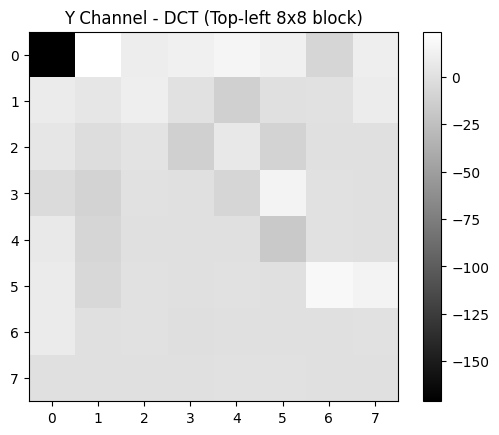

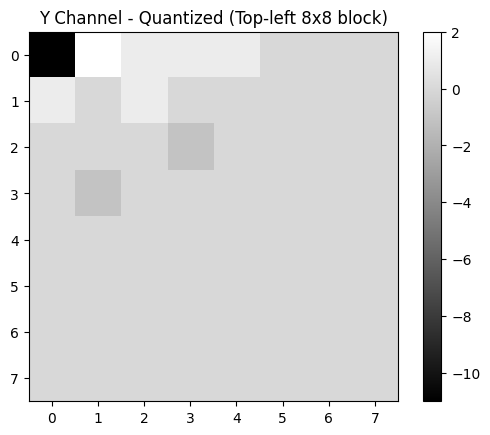

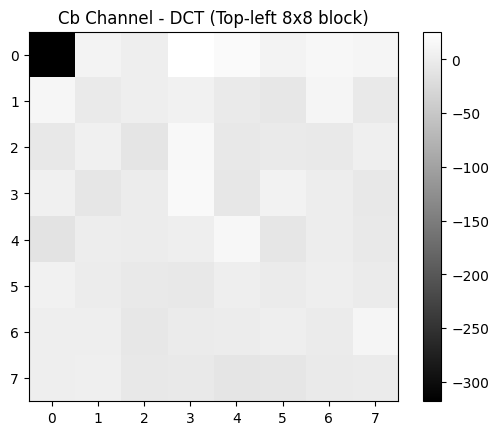

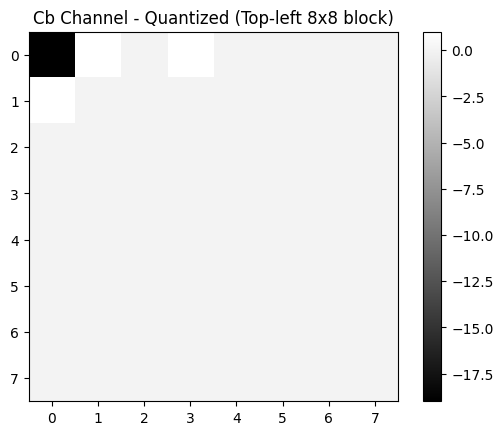

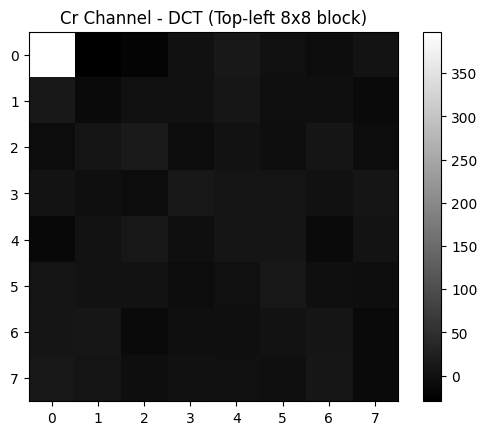

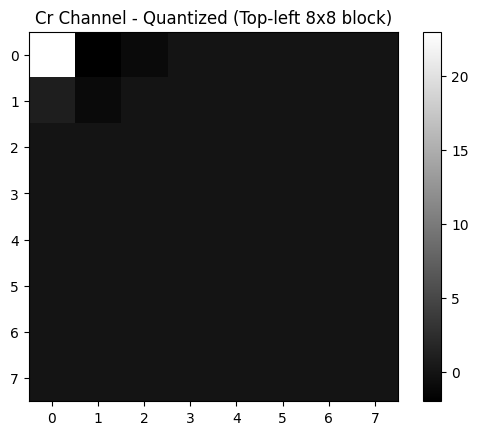

Text(0.5, 1.0, 'Cr Channel - DCT')

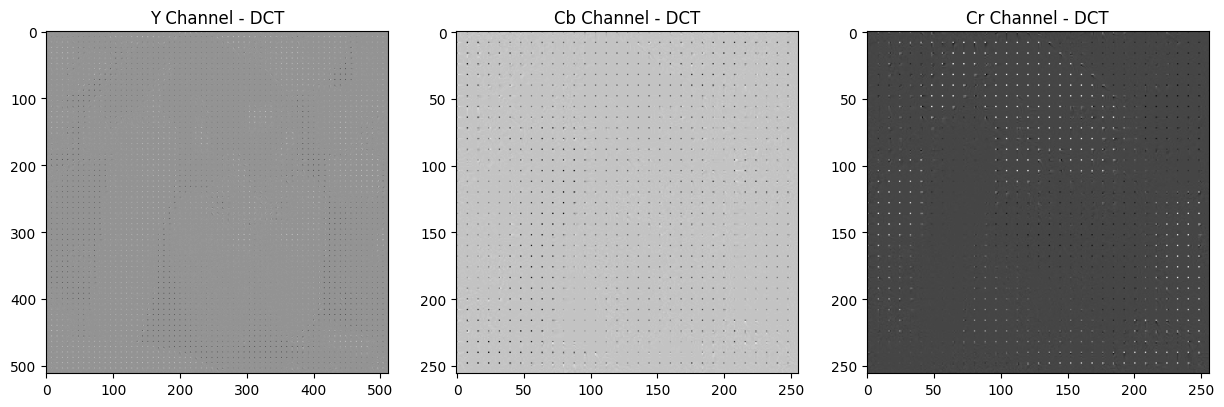

In [ ]:
import matplotlib.pyplot as plt

# Function to display an 8x8 block
def display_block(block, title):
    plt.imshow(block, cmap='gray')
    plt.colorbar()
    plt.title(title)
    plt.show()

# Updated process_channel function to also display intermediate results
def process_channel_with_display(channel, quant_table, channel_name=""):
    h, w = channel.shape
    processed_channel = np.zeros_like(channel, dtype=int)
    dct_result = np.zeros_like(channel, dtype=float)

    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = channel[i:i+8, j:j+8]

            # Step 1: Apply DCT
            dct_block = dct_2d(block - 128)
            dct_result[i:i+8, j:j+8] = dct_block  # Store DCT result for visualization

            # Step 2: Quantize the DCT block
            quantized_block = quantize_block(dct_block, quant_table)
            processed_channel[i:i+8, j:j+8] = quantized_block

            # Display a sample block result for one block (top-left corner)
            if i == 0 and j == 0:
                display_block(dct_block, f"{channel_name} Channel - DCT (Top-left 8x8 block)")
                display_block(quantized_block, f"{channel_name} Channel - Quantized (Top-left 8x8 block)")

    return processed_channel, dct_result

# Apply DCT and quantization to YCbCr channels with visualization
processed_y, dct_y = process_channel_with_display(y_channel, LUMINANCE_QUANT_TABLE, "Y")
processed_cb, dct_cb = process_channel_with_display(cb_channel, CHROMINANCE_QUANT_TABLE, "Cb")
processed_cr, dct_cr = process_channel_with_display(cr_channel, CHROMINANCE_QUANT_TABLE, "Cr")

# Display the full DCT and quantized channels
plt.figure(figsize=(15, 10))

# Full DCT images
plt.subplot(1, 3, 1)
plt.imshow(dct_y, cmap='gray')
plt.title("Y Channel - DCT")

plt.subplot(1, 3, 2)
plt.imshow(dct_cb, cmap='gray')
plt.title("Cb Channel - DCT")

plt.subplot(1, 3, 3)
plt.imshow(dct_cr, cmap='gray')
plt.title("Cr Channel - DCT")



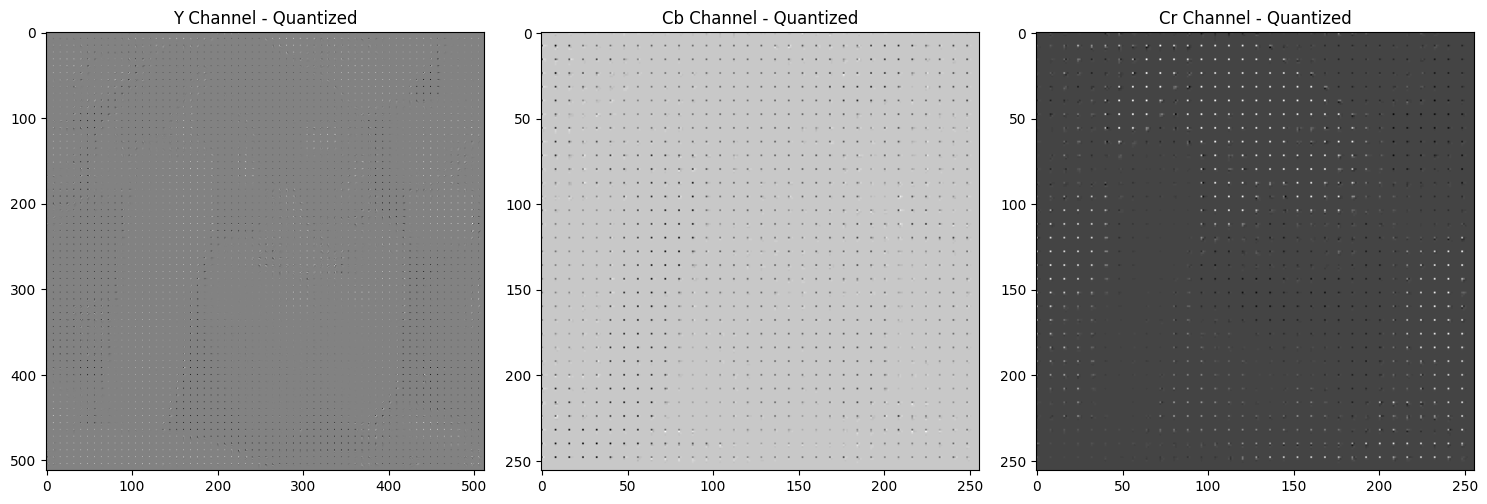

In [ ]:
# Full Quantized images
plt.figure(figsize=(15, 10))
plt.subplot(1, 3, 1)
plt.imshow(processed_y, cmap='gray')
plt.title("Y Channel - Quantized")

plt.subplot(1, 3, 2)
plt.imshow(processed_cb, cmap='gray')
plt.title("Cb Channel - Quantized")

plt.subplot(1, 3, 3)
plt.imshow(processed_cr, cmap='gray')
plt.title("Cr Channel - Quantized")

plt.tight_layout()
plt.show()


In [ ]:
import heapq
from collections import Counter
import numpy as np

# Define the zigzag order for an 8x8 block
# Define the zigzag order for an 8x8 block
ZIGZAG_ORDER = [
    (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
    (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
    (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
    (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
    (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
    (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
    (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
    (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
]
 # same as before

# Zigzag function to reorder quantized block into a 1D list
def zigzag_order(block):
    return [block[i, j] for i, j in ZIGZAG_ORDER]

# Run-length encoding (RLE) function
def run_length_encoding(zigzag_list):
    code = []
    run = 0
    for i in range(len(zigzag_list)):
        if zigzag_list[i] == 0:
            run += 1
        else:
            size = int(np.floor(np.log2(abs(zigzag_list[i])) + 1)) if zigzag_list[i] != 0 else 0
            code.append(((run, size), zigzag_list[i]))  # Store run, size, and amplitude
            run = 0
    code.append((0, 0))  # End of block marker
    return code

# Function to apply zigzag and RLE encoding on quantized blocks
def process_zigzag_and_rle(channel_data):
    h, w = channel_data.shape
    rle_encoded_data = []
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = channel_data[i:i+8, j:j+8]
            zigzag_list = zigzag_order(block)
            rle_encoded_block = run_length_encoding(zigzag_list)
            rle_encoded_data.append(rle_encoded_block)
    return rle_encoded_data
# Apply zigzag and RLE on the processed Y, Cb, and Cr channels
rle_y = process_zigzag_and_rle(processed_y)
rle_cb = process_zigzag_and_rle(processed_cb)
rle_cr = process_zigzag_and_rle(processed_cr)
# Output the RLE results
print("RLE Encoded Y Channel:", rle_y)
print("RLE Encoded Cb Channel:", rle_cb)
print("RLE Encoded Cr Channel:", rle_cr)

# Concatenate RLE data for all components
total_rle_data = rle_y + rle_cb + rle_cr
print("total_rel_data:",total_rle_data)

# Separate DC and AC components
DC_list = []
AC_list = []
for block_rle in total_rle_data:
    DC_list.append(block_rle[0][1])  # DC amplitude
    for ac_tuple in block_rle[1:]:
        if ac_tuple == (0, 0):  # End of block marker
            AC_list.append((0, 0))  # End of block marker
            break
        else:
            run, size = ac_tuple[0]
            AC_list.append((run, size))

# Function to generate the differential DC encoding
def dc_differential_encoding(dc_values):
    dc_diffs = [dc_values[0]] if dc_values else []
    for i in range(1, len(dc_values)):
        dc_diffs.append(dc_values[i] - dc_values[i-1])
    return dc_diffs

# Run-length encoding for AC components (extracting only run, size pairs)
def ac_run_length_encoding(ac_values):
    encoded_ac = []
    for ac_tuple in ac_values:
        if isinstance(ac_tuple, tuple) and len(ac_tuple) == 2:
            run, size = ac_tuple  # Use only (run, size) for Huffman coding
            if (run, size) == (0, 0):  # End-of-block marker
                encoded_ac.append((0, 0))
            else:
                encoded_ac.append((run, size))
    return encoded_ac

# Define Node and HuffmanCoding classes for Huffman tree and code generation
class Node:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

class HuffmanCoding:
    def __init__(self, frequencies):
        self.frequencies = frequencies
        self.root = None

    def build_tree(self):
        if not self.frequencies:
            return None
        heap = [Node(freq, symbol) for symbol, freq in self.frequencies.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            merged = Node(left.freq + right.freq, left=left, right=right)
            heapq.heappush(heap, merged)
        self.root = heap[0] if heap else None
        return self.root

    def generate_codes(self, node=None, prefix="", codebook=None):
        if codebook is None:
            codebook = {}
        if node is None:
            node = self.root

        if node is not None:
            if node.symbol is not None:
                codebook[node.symbol] = prefix
            else:
                self.generate_codes(node.left, prefix + "0", codebook)
                self.generate_codes(node.right, prefix + "1", codebook)
        return codebook

# Generate Huffman codes for DC and AC components
def apply_huffman_coding(dc_values, ac_values):
    dc_diffs = dc_differential_encoding(dc_values)
    ac_encoded = ac_run_length_encoding(ac_values)

    dc_frequencies = Counter(dc_diffs)
    ac_frequencies = Counter(x for x in ac_encoded if x != (0, 0))

    dc_codebook, ac_codebook = {}, {}

    if dc_frequencies:
        dc_huffman = HuffmanCoding(dc_frequencies)
        dc_huffman.build_tree()
        dc_codebook = dc_huffman.generate_codes()

    if ac_frequencies:
        ac_huffman = HuffmanCoding(ac_frequencies)
        ac_huffman.build_tree()
        ac_codebook = ac_huffman.generate_codes()

    return dc_codebook, ac_codebook

# Apply Huffman coding
dc_codebook, ac_codebook = apply_huffman_coding(DC_list, AC_list)
print("DC Components (Y, Cb, Cr):", DC_list)
print("AC Components (Y, Cb, Cr):", AC_list)
# Print the Huffman codes for DC and AC components
print("Huffman Codes for DC Components:")
for dc_val, code in dc_codebook.items():
    print(f"{dc_val}: {code}")

print("\nHuffman Codes for AC Components:")
for ac_val, code in ac_codebook.items():
    print(f"{ac_val}: {code}")
import heapq
from collections import Counter
import numpy as np

# Define the zigzag order for an 8x8 block
# Define the zigzag order for an 8x8 block
ZIGZAG_ORDER = [
    (0, 0), (0, 1), (1, 0), (2, 0), (1, 1), (0, 2), (0, 3), (1, 2),
    (2, 1), (3, 0), (4, 0), (3, 1), (2, 2), (1, 3), (0, 4), (0, 5),
    (1, 4), (2, 3), (3, 2), (4, 1), (5, 0), (6, 0), (5, 1), (4, 2),
    (3, 3), (2, 4), (1, 5), (0, 6), (0, 7), (1, 6), (2, 5), (3, 4),
    (4, 3), (5, 2), (6, 1), (7, 0), (7, 1), (6, 2), (5, 3), (4, 4),
    (3, 5), (2, 6), (1, 7), (2, 7), (3, 6), (4, 5), (5, 4), (6, 3),
    (7, 2), (7, 3), (6, 4), (5, 5), (4, 6), (3, 7), (4, 7), (5, 6),
    (6, 5), (7, 4), (7, 5), (6, 6), (5, 7), (6, 7), (7, 6), (7, 7)
]
 # same as before

# Zigzag function to reorder quantized block into a 1D list
def zigzag_order(block):
    return [block[i, j] for i, j in ZIGZAG_ORDER]

# Run-length encoding (RLE) function
def run_length_encoding(zigzag_list):
    code = []
    run = 0
    for i in range(len(zigzag_list)):
        if zigzag_list[i] == 0:
            run += 1
        else:
            size = int(np.floor(np.log2(abs(zigzag_list[i])) + 1)) if zigzag_list[i] != 0 else 0
            code.append(((run, size), zigzag_list[i]))  # Store run, size, and amplitude
            run = 0
    code.append((0, 0))  # End of block marker
    return code

# Function to apply zigzag and RLE encoding on quantized blocks
def process_zigzag_and_rle(channel_data):
    h, w = channel_data.shape
    rle_encoded_data = []
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = channel_data[i:i+8, j:j+8]
            zigzag_list = zigzag_order(block)
            rle_encoded_block = run_length_encoding(zigzag_list)
            rle_encoded_data.append(rle_encoded_block)
    return rle_encoded_data
# Apply zigzag and RLE on the processed Y, Cb, and Cr channels
rle_y = process_zigzag_and_rle(processed_y)
rle_cb = process_zigzag_and_rle(processed_cb)
rle_cr = process_zigzag_and_rle(processed_cr)
# Output the RLE results
print("RLE Encoded Y Channel:", rle_y)
print("RLE Encoded Cb Channel:", rle_cb)
print("RLE Encoded Cr Channel:", rle_cr)

# Concatenate RLE data for all components
total_rle_data = rle_y + rle_cb + rle_cr
print("total_rel_data:",total_rle_data)

# Separate DC and AC components
DC_list = []
AC_list = []
for block_rle in total_rle_data:
    DC_list.append(block_rle[0][1])  # DC amplitude
    for ac_tuple in block_rle[1:]:
        if ac_tuple == (0, 0):  # End of block marker
            AC_list.append((0, 0))  # End of block marker
            break
        else:
            run, size = ac_tuple[0]
            AC_list.append((run, size))

# Function to generate the differential DC encoding
def dc_differential_encoding(dc_values):
    dc_diffs = [dc_values[0]] if dc_values else []
    for i in range(1, len(dc_values)):
        dc_diffs.append(dc_values[i] - dc_values[i-1])
    return dc_diffs

# Run-length encoding for AC components (extracting only run, size pairs)
def ac_run_length_encoding(ac_values):
    encoded_ac = []
    for ac_tuple in ac_values:
        if isinstance(ac_tuple, tuple) and len(ac_tuple) == 2:
            run, size = ac_tuple  # Use only (run, size) for Huffman coding
            if (run, size) == (0, 0):  # End-of-block marker
                encoded_ac.append((0, 0))
            else:
                encoded_ac.append((run, size))
    return encoded_ac

# Define Node and HuffmanCoding classes for Huffman tree and code generation
class Node:
    def __init__(self, freq, symbol=None, left=None, right=None):
        self.freq = freq
        self.symbol = symbol
        self.left = left
        self.right = right

    def __lt__(self, other):
        return self.freq < other.freq

class HuffmanCoding:
    def __init__(self, frequencies):
        self.frequencies = frequencies
        self.root = None

    def build_tree(self):
        if not self.frequencies:
            return None
        heap = [Node(freq, symbol) for symbol, freq in self.frequencies.items()]
        heapq.heapify(heap)
        while len(heap) > 1:
            left = heapq.heappop(heap)
            right = heapq.heappop(heap)
            merged = Node(left.freq + right.freq, left=left, right=right)
            heapq.heappush(heap, merged)
        self.root = heap[0] if heap else None
        return self.root

    def generate_codes(self, node=None, prefix="", codebook=None):
        if codebook is None:
            codebook = {}
        if node is None:
            node = self.root

        if node is not None:
            if node.symbol is not None:
                codebook[node.symbol] = prefix
            else:
                self.generate_codes(node.left, prefix + "0", codebook)
                self.generate_codes(node.right, prefix + "1", codebook)
        return codebook

# Generate Huffman codes for DC and AC components
def apply_huffman_coding(dc_values, ac_values):
    dc_diffs = dc_differential_encoding(dc_values)
    ac_encoded = ac_run_length_encoding(ac_values)

    dc_frequencies = Counter(dc_diffs)
    ac_frequencies = Counter(x for x in ac_encoded if x != (0, 0))

    dc_codebook, ac_codebook = {}, {}

    if dc_frequencies:
        dc_huffman = HuffmanCoding(dc_frequencies)
        dc_huffman.build_tree()
        dc_codebook = dc_huffman.generate_codes()

    if ac_frequencies:
        ac_huffman = HuffmanCoding(ac_frequencies)
        ac_huffman.build_tree()
        ac_codebook = ac_huffman.generate_codes()

    return dc_codebook, ac_codebook

# Apply Huffman coding
dc_codebook, ac_codebook = apply_huffman_coding(DC_list, AC_list)
print("DC Components (Y, Cb, Cr):", DC_list)
print("AC Components (Y, Cb, Cr):", AC_list)
# Print the Huffman codes for DC and AC components
print("Huffman Codes for DC Components:")
for dc_val, code in dc_codebook.items():
    print(f"{dc_val}: {code}")

print("\nHuffman Codes for AC Components:")
for ac_val, code in ac_codebook.items():
    print(f"{ac_val}: {code}")





RLE Encoded Y Channel: [[((0, 4), -11), ((0, 2), 2), ((0, 1), 1), ((2, 1), 1), ((0, 1), 1), ((0, 1), 1), ((3, 1), -1), ((2, 1), 1), ((2, 1), -1), (0, 0)], [((0, 4), -11), ((1, 1), -1), ((4, 1), 1), ((3, 1), 1), ((1, 1), -1), ((0, 1), -1), (0, 0)], [((0, 4), -13), ((1, 1), 1), ((2, 1), 1), ((0, 1), 1), ((0, 1), -1), ((0, 1), -1), ((0, 1), 1), ((2, 1), -1), (0, 0)], [((0, 4), -14), ((1, 1), 1), ((0, 1), 1), (0, 0)], [((0, 4), -14), ((0, 1), -1), ((0, 1), 1), ((11, 1), -1), (0, 0)], [((0, 4), -13), ((17, 1), 1), ((0, 1), 1), (0, 0)], [((0, 4), -12), ((0, 1), 1), ((1, 1), -1), ((1, 1), 1), ((0, 1), -1), ((0, 1), -1), ((2, 1), 1), ((7, 1), -1), (0, 0)], [((0, 4), -14), ((2, 1), -1), ((4, 1), -1), ((2, 1), 1), ((7, 1), 1), (0, 0)], [((0, 4), -15), ((1, 2), -2), ((2, 1), -1), ((1, 1), 1), ((0, 1), -1), ((0, 1), -1), (0, 0)], [((0, 5), -16), ((0, 1), 1), ((0, 1), -1), ((8, 1), 1), ((0, 1), -1), (0, 0)], [((0, 4), -8), ((0, 4), -12), ((0, 4), 9), ((0, 2), 2), ((0, 3), -7), ((0, 2), 3), ((0, 1),

In [ ]:
#Function to calculate the compression ratio
def calculate_compression_ratio(original_data_binary, compressed_data_binary):
    original_size_bits = len(original_data_binary)
    compressed_size_bits = len(compressed_data_binary)
    compression_ratio = original_size_bits / compressed_size_bits if compressed_size_bits > 0 else float('inf')
    return original_size_bits, compressed_size_bits, compression_ratio
# Function to encode the data using the generated Huffman codes
def encode_with_huffman(dc_codebook, ac_codebook, total_rle_data):
    encoded_data = ""
    for block in total_rle_data:
        # Encode the DC component
        dc_value = block[0][1]
        dc_huffman_code = dc_codebook.get(dc_value, "")
        encoded_data += dc_huffman_code

        # Encode the AC components
        for ac_tuple in block[1:]:
            if ac_tuple == (0, 0):  # End of block marker
                ac_huffman_code = ac_codebook.get((0, 0), "")
                encoded_data += ac_huffman_code
                break
            else:
                run, size = ac_tuple[0]
                ac_value = ac_tuple[1]
                ac_huffman_code = ac_codebook.get((run, size), "")
                encoded_data += ac_huffman_code
    return encoded_data

# Apply zigzag and RLE on the processed Y, Cb, and Cr channels
rle_y = process_zigzag_and_rle(processed_y)
rle_cb = process_zigzag_and_rle(processed_cb)
rle_cr = process_zigzag_and_rle(processed_cr)

# Concatenate RLE data for all components
total_rle_data = rle_y + rle_cb + rle_cr

# Separate DC and AC components
DC_list = [block_rle[0][1] for block_rle in total_rle_data]
AC_list = [ac_tuple[1] for block_rle in total_rle_data for ac_tuple in block_rle[1:] if ac_tuple != (0, 0)]

# Apply Huffman coding
dc_codebook, ac_codebook = apply_huffman_coding(DC_list, AC_list)

# Encode the data using Huffman codes
encoded_data = encode_with_huffman(dc_codebook, ac_codebook, total_rle_data)

# Print the encoded binary data
print("Encoded Binary Data:")
print(encoded_data)

# Optionally, print a portion (first 100 bits) for clarity
print("Sample of Encoded Binary Data (First 100 bits):")
print(encoded_data[:100])

# Calculate the compression ratio
original_data_binary = ''.join([bin(dc)[2:].zfill(16) for dc in DC_list]) + \
                        ''.join([bin(ac)[2:].zfill(16) for ac in AC_list])
compressed_data_binary = encoded_data

original_size_bits, compressed_size_bits, compression_ratio = calculate_compression_ratio(original_data_binary, compressed_data_binary)

# Display the results
print("\n--- Compression Results ---")
print(f"Original Data Size: {original_size_bits} bits")
print(f"Compressed Data Size: {compressed_size_bits} bits")
print(f"Compression Ratio: {compression_ratio}")


Encoded Binary Data:
0101001010100110101011111101111111011110101011010101111110111111110101100011111111101101000111010111101011011111101101011110101001001111101000110101000110111110100011011110100010111101011111111011111111110000101110000111110111110000100011000000111111010011111111110000001100100011110110001111011111101000110111101000110101000110110101001001101010011110100011110101010110110101111110111000011010101000111110111010011010111110000000110101010110101001000011100110000000000000101001111111011011101011111111111100000000000100001010111100001111111001011111111011000111101010111111011111110111101010111111011111000011111111110101010011010011010000000011001111101000110111101000110111101000101010100100111010111000010011101001010100010000110101010100110101100101000101010001010100011100011111011101010010011010001100101000110011110100001101000110110101001001101001110010101010101111101000101100011000001011111111111101010101010100110001011000110110000000000011111101010100000111000000111